In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew

In [80]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [81]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [82]:
train_ID = train['Id']
test_ID = test['Id']
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("\nThe test data size after dropping Id feature is: {}".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 

The test data size after dropping Id feature is: (1459, 79)



 mu = 180921.20 and sigma = 79415.29



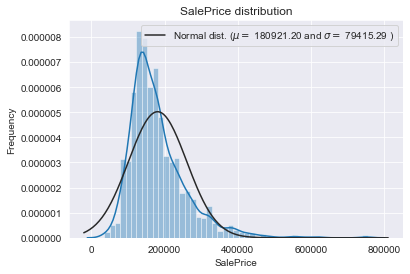

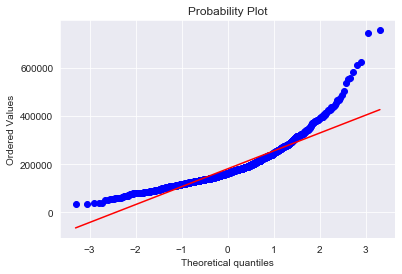

In [83]:
sns.distplot(train['SalePrice'],fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40


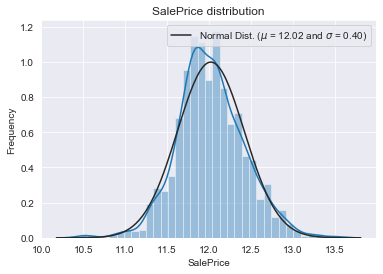

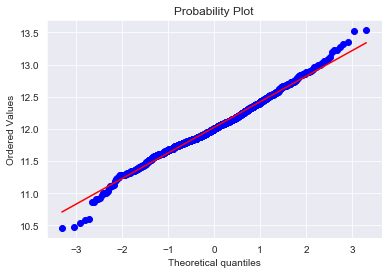

In [84]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(train['SalePrice'])
print("\n mu = {:.2f} and sigma = {:.2f}".format(mu, sigma))

plt.legend(['Normal Dist. ($\mu$ = {:.2f} and $\sigma$ = {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig=plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [85]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


# Find Missing data

In [86]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(5)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797


Text(0.5, 1.0, 'Percent missing data by feature')

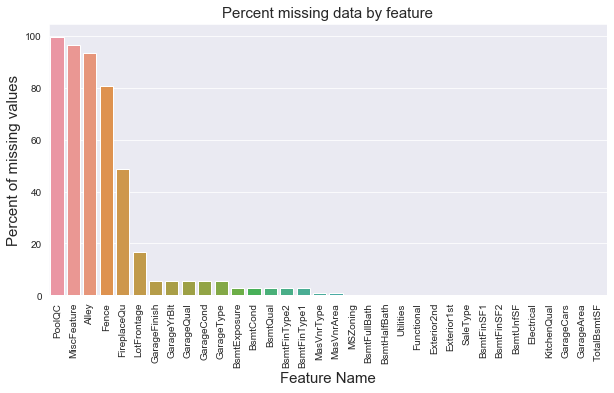

In [87]:
fid = plt.figure(figsize=(10,5))
plt.xticks(rotation = '90')
sns.barplot(x=missing_data.index, y='Missing Ratio', data=missing_data)
plt.xlabel('Feature Name', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# Data Correlation

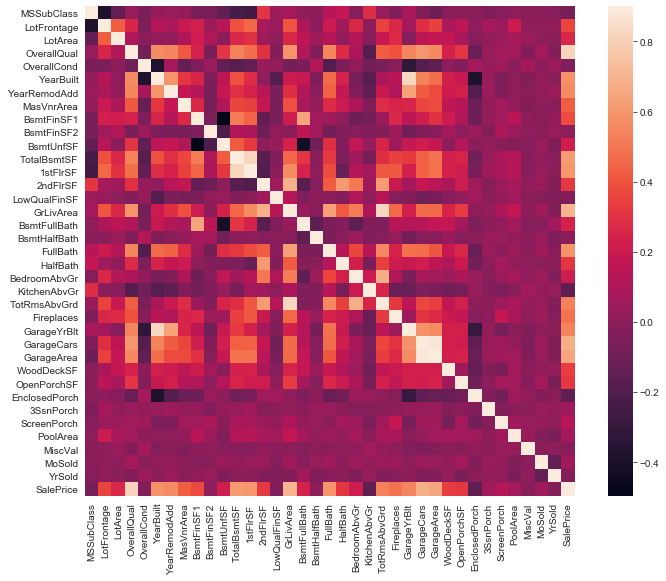

In [88]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [89]:
features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
for feature in features:
    all_data[feature] = all_data[feature].fillna('None')

# Fill the missing LotFrontage

In [90]:
# From the heatmap, it seems 'LotArea' and '1stFlrSF' has more correlation with 'LotFrontage'
all_data['LotFrontage'] = all_data.groupby(by=['Neighborhood'])["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Fill Garage Features (Discete or Continous)

In [91]:
garage_discrete = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_continous = ['GarageYrBlt', 'GarageArea', 'GarageCars']

for i in garage_discrete:
    all_data[i] = all_data[i].fillna('None')
    
for j in garage_continous:
    all_data[j] = all_data[j].fillna(0)

# Fill Bsmt-related Features (Discrete or Continous)

In [92]:
bsmt_discrete = ['BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']
bsmt_continous = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

for i in bsmt_discrete:
    all_data[i] = all_data[i].fillna('None')
for j in bsmt_continous:
    all_data[j] = all_data[j].fillna(0)

# Fill MasVnrTye and MasVnrArea

In [93]:
# If one of MasVnrType or MasVnrArea missed, we can predict one feature by another
# Otherwise, if both missed, we can fill it with zero

MasVnrMedian = all_data.groupby('MasVnrType')['MasVnrArea'].median()
mtypena = all_data[(all_data['MasVnrType'].isnull()) & (all_data['MasVnrArea'].notnull())][['MasVnrType','MasVnrArea']]

for i in mtypena.index:
    v = all_data.loc[i,['MasVnrArea']].values
    all_data.loc[i,['MasVnrType']] = MasVnrMedian.index[np.abs(v-MasVnrMedian).astype('float64').argmin()]
    print(all_data.loc[i,['MasVnrType']])

all_data['MasVnrType'] = all_data["MasVnrType"].fillna("None")
all_data['MasVnrArea'] = all_data["MasVnrArea"].fillna(0)

MasVnrType    Stone
Name: 2610, dtype: object


# Fill MSZoning

In [94]:
# Find the most common feature in MSZoning to fill it.
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# Fill Utilities

For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA .
Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling.
We can then safely remove it.

In [95]:
all_data = all_data.drop(['Utilities'], axis=1)

# Fill Functional

In [96]:
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])

# Fill Electrical

In [97]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# Fill KitchenQual

In [98]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# Fill Exterior1st and Exterior2nd 

In [99]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

# Fill SaleType

In [100]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# Check remaining missing values if any 

In [101]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


# Transform some categorical data to str data

In [102]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Label Encoding some categorical variables

 some categorical variables that may contain information in their ordering set

In [103]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 78)


# Add new feature: total house square feet

In [104]:
# note that:
# 1stFlrSF + 2ndFlrSF + LowQualFinSF = GrLivArea
# BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF
# Ignore LotArea, it seems do nothing with individual house area
# ignore MasVnrArea, masonry veneer is a construction material used on the outside walls of homes and commercial buildings.
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['GrLivArea'] + all_data['GarageArea'] + all_data['WoodDeckSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] + all_data['PoolArea']

# Since I'm going to use TotalSF as the only criteria, its components should be deleted
# features = ['TotalBsmtSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
# for feature in features:
#     all_data = all_data.drop([feature], axis=1)

In [105]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   int64  
 5   Alley          2919 non-null   int64  
 6   LotShape       2919 non-null   int64  
 7   LandContour    2919 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   int64  
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

# Skewed features

Linear regression model satisfies linearity, independence, homogeneity of variance and normality without losing information. It uses parapter $\lambda$ to do linear transformation so that the data get near to Normal Distribution. 

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


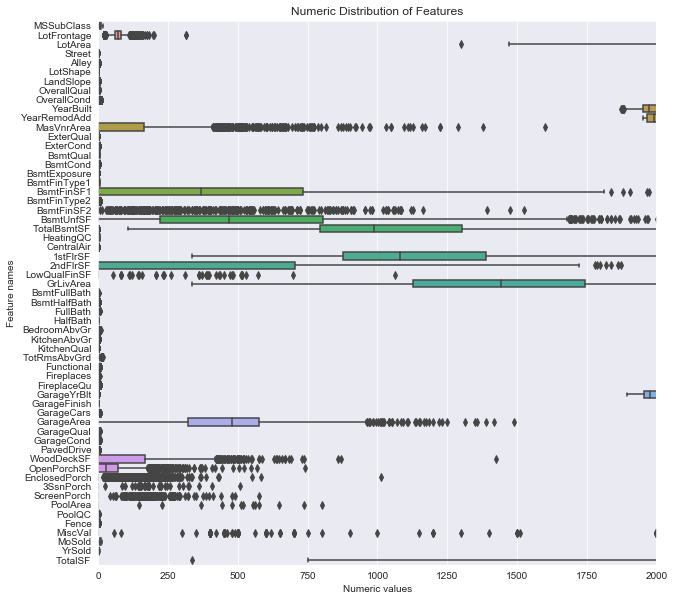

In [106]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
fig = plt.figure(figsize=(10,10))
sns.boxplot(data=all_data[numeric_feats], orient="h")
plt.title('Numeric Distribution of Features')
plt.xlim([0, 2e3])
plt.ylabel("Feature names")
plt.xlabel("Numeric values")

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

There are 59 skewed numerical features to Box Cox transform


Text(0.5, 0, 'Numeric values')

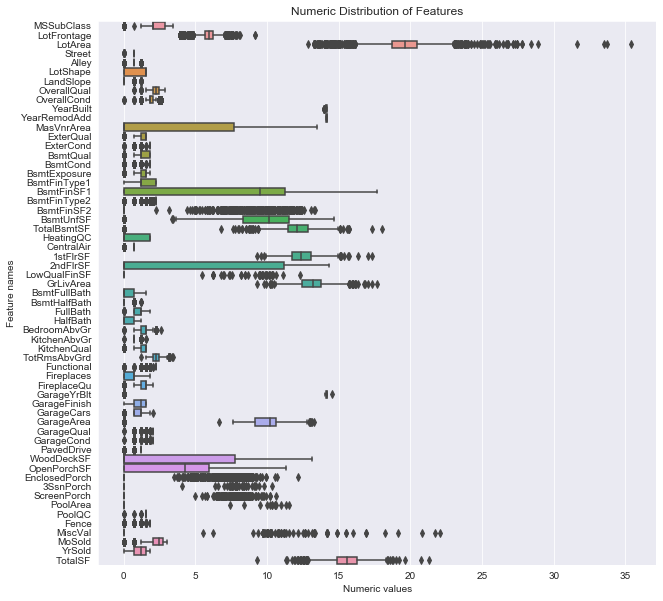

In [107]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
fig = plt.figure(figsize=(10,10))
sns.boxplot(data=all_data[numeric_feats], orient="h")
plt.title('Numeric Distribution of Features')
plt.ylabel("Feature names")
plt.xlabel("Numeric values")

# Get train and test

In [108]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
train = all_data[:ntrain]
test = all_data[ntrain:]

(2919, 221)


# Model

In [109]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [110]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Try Models
RobustScaler: outlier

MinMaxScaler: sentitive to outlier, it only fits in one distribution

StandardScaler: fit to Normal Distribution, outlier may impact the transformed distribution

In [111]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [112]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [113]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [114]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [115]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# Scores

In [116]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1232 (0.0169)



In [117]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1233 (0.0170)



In [118]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1259 (0.0127)



In [119]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1238 (0.0136)



In [120]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1203 (0.0091)



# Ensemble method

In [121]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [122]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1189 (0.0151)



In [123]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [124]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1185 (0.0148)


# ensemble xgboost

In [125]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# train

In [126]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08252023083302065


ensemble = stacked_pred*0.80 + xgb_pred*0.20

In [128]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07928356150272449


In [129]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred * 0.80 + xgb_train_pred * 0.20))

RMSLE score on train data:
0.08000056715870021


In [130]:
ensemble = stacked_pred*0.80 + xgb_pred*0.20

In [131]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)